# Libraries and functions

kaggle task link: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [45]:
pip show scikit-learn

Name: scikit-learn
Version: 1.3.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\user\anaconda3\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: scikit-learn-intelex, yellowbrick
Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install --upgrade scikit-learn

In [3]:
# pip install yellowbrick

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
sns.set()

# from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler
# from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import (KMeans, MeanShift, estimate_bandwidth, 
                             AgglomerativeClustering, HDBSCAN) # HDBSCAN from 1.3.0
from sklearn.metrics import silhouette_score

from tqdm.auto import tqdm

RANDOM_STATE = 666
PALETTE = {
    -1: "gray",
    0: "red",
    1: "blue",
    2: "green",
    3: "yellow",
    4: "orange",
    5: "purple",
    6: "brown",
    7: "black",
    8: "pink",
    9: "violet",
    10: "cyan",
    11: "magenta",
    12: "gold",
    13: "silver",
    14: "beige",
    15: "turquoise",
    16: "navy",
    17: "lime"
}

In [27]:
# Среднее внутрикластерное растояние
def average_intracluster_distance(X, labels):
    """
    X: массив данных
    labels: метки кластеров для каждой точки данных
    """
    n_clusters = len(np.unique(labels))

    intracluster_distances = []

    for cluster_id in np.unique(labels):
        cluster_points = X[labels == cluster_id]

        if len(cluster_points) > 1:  # нужно минимум 2 точки для вычисления расстояния
            dists = distance.pdist(cluster_points)  # попарные расстояния между точками в кластере
            intracluster_distances.append(np.mean(dists))

    return np.mean(intracluster_distances)


# Среднее межкластерное расстояние
def average_intrecluster_distance(center):
    """
    center: kmeans.cluster_centers_ [ [], [], [] ... ]
    """
    distances = distance.cdist(center, center) # Вычисляем попарные расстояния
    mean_intercluster_distance = distances.sum() / (2 * len(center)) # Получаем среднее значение из попарных расстояний

    return mean_intercluster_distance


# Реализация метода локтя с помощью from yellowbrick.cluster import KElbowVisualizer
def get_cluster_num(max_clusters, X):
    """
    max_clusters: int, макс число кластеров
    X: массив данных
    """
    visualizer = KElbowVisualizer(KMeans(), k=(2, max_clusters),
                                  random_state=RANDOM_STATE)
    visualizer.fit(X)
    visualizer.poof()
    plt.show()


def print_metrics(metrics):
    for k in metrics.keys():
      print('{} = {}'.format(k, metrics.get(k, 'unknown')))


# 2d визуализация
def visualization_2d(data, col, cols, labels):

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    for c in range(2):
      carry = data[data.is_Female == c][cols]
      title = 'Male' if c == 0 else 'Female'

      for r in range(3):
        sns.scatterplot(ax=axes[c, r], data=carry,
                        x=labels.get('x')[r], y=labels.get('y')[r],
                        hue=col, palette=PALETTE)
        axes[c, r].legend([], [])
        axes[c, r].set(title=title)
    
    plt.show()
    # fig.legend(PALETTE, loc="center right")


# 3d визуализация
def visualization_3d(data, col):

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection='3d')

    for i in range(data[col].min(), data[col].max() + 1):
      carry = data[data[col] == i]
      ax.scatter(carry['Age'], carry['Annual Income (k$)'],
                 carry['Spending Score (1-100)'], s=140, label=("cluster " + str(i)), )


    ax.set_xlabel('Age-->')
    ax.set_ylabel('Income (k$)-->')
    ax.set_zlabel('Spending Score (1-100)-->')
    ax.legend()


def barplot_of_cluster_size(data, col):
    carry = data[[col]].groupby(by=col).agg(Amount=(col, 'count'))
    sns.barplot(data=carry, x=carry.index, y='Amount', order=carry.sort_values(by='Amount', ascending=False).index)
    plt.show(sns)


def info_by_cluster(data, col):
    display(
      data.groupby(by=[col, 'is_Female']).agg({
          'Age': ['count', 'mean', 'median'],
          'Annual Income (k$)': ['mean', 'median'],
          'Spending Score (1-100)': ['mean', 'median']
      }).sort_values(by=[col,	'is_Female'])
    )

# Upload data

In [6]:
file = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTlrBVZkT_CPPnnZQ1lcKYL6rHEbrZfXeIlOpzL5N0SRS08ElxkROTzuKZEeOJDjMBan7K0XHXvehor/pub?gid=209893247&single=true&output=csv'
data = pd.read_csv(file)

In [7]:
display(
    data.info(),
    data.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


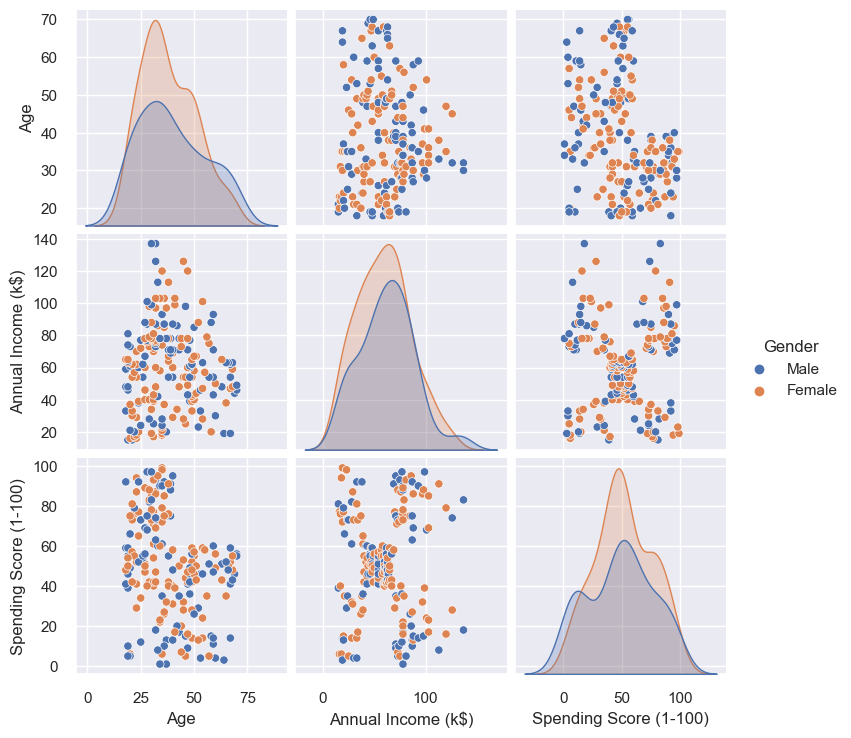

In [8]:
sns.pairplot(data=data[data.columns[1:]], hue='Gender')
plt.show(sns)

Признаки имеют разные масштабы, поэтому необходима процедура маштабирования.

Маштабировать будем с помощью RobustScaler, так как распределение по доходу (Annual Income) имеет хвост. После маштабирования - стандартизируем данные с помощью StandardScaler.

In [9]:
data['Gender'] = data['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
data.rename(columns={ 'Gender': 'is_Female' }, inplace=True)

# Preprocessing

## Scaling and standardization

* масштабирование и стандартизация признаков
* алгоритмы кластеризации чувствителены к масштабу признаков, те необходимо масштабировать данные. Это связано с тем, что, при формировании кластеров, мы измеряем расстояние (в частности, Евклидово расстояние), и признаки с большим масштабом будут иметь больший вес.

**RobustScaler**
* масштабирование через вычитание медианы и деление на межквартильный размах (к75 - к25)

**StandardScaler**
* стандартизация данных приводит к mean=0 и var=1


Комбинированное RobustScaler и StandardScaler уменьшает влияние выбросов на масштабирование, а затем обеспечивает стандартизацию данных.

In [10]:
# scaling
# with_centering - центрирование перед масштабированием

transformer = RobustScaler(with_centering=True, with_scaling=True,
                           quantile_range=(25.0, 75.0), unit_variance=False)
X = transformer.fit_transform(data[data.columns[1:]])

display(
    X[:5],
    [np.var(X[:, 0]), np.mean(X[:, 0])],
    [np.var(X[:, 2]), np.mean(X[:, 2])]
)

array([[-1.        , -0.83950617, -1.2739726 , -0.2875817 ],
       [-1.        , -0.74074074, -1.2739726 ,  0.81045752],
       [ 0.        , -0.79012346, -1.24657534, -1.1503268 ],
       [ 0.        , -0.64197531, -1.24657534,  0.70588235],
       [ 0.        , -0.24691358, -1.21917808, -0.26143791]])

[0.2464, -0.44]

[0.5152084068305498, -0.02575342465753426]

In [11]:
# standardization

transformer = StandardScaler(with_mean=True, with_std=True)
X = transformer.fit_transform(X)

display(
    X[:5],
    [np.var(X[:, 0]), np.mean(X[:, 0])],
    [np.var(X[:, 2]), np.mean(X[:, 2])]
)

array([[-1.12815215, -1.42456879, -1.73899919, -0.43480148],
       [-1.12815215, -1.28103541, -1.73899919,  1.19570407],
       [ 0.88640526, -1.3528021 , -1.70082976, -1.71591298],
       [ 0.88640526, -1.13750203, -1.70082976,  1.04041783],
       [ 0.88640526, -0.56336851, -1.66266033, -0.39597992]])

[1.0000000000000002, -3.1086244689504386e-17]

[1.0000000000000002, 0.0]

In [12]:
data_transformed = pd.DataFrame(data=X,
                                columns=['is_Female', 'Age', 'Annual Income', 'Spending Score'])
data_transformed.head()

,is_Female,Age,Annual Income,Spending Score
0,-1.128152,-1.424569,-1.738999,-0.434801
1,-1.128152,-1.281035,-1.738999,1.195704
2,0.886405,-1.352802,-1.700830,-1.715913
3,0.886405,-1.137502,-1.700830,1.040418
4,0.886405,-0.563369,-1.662660,-0.395980


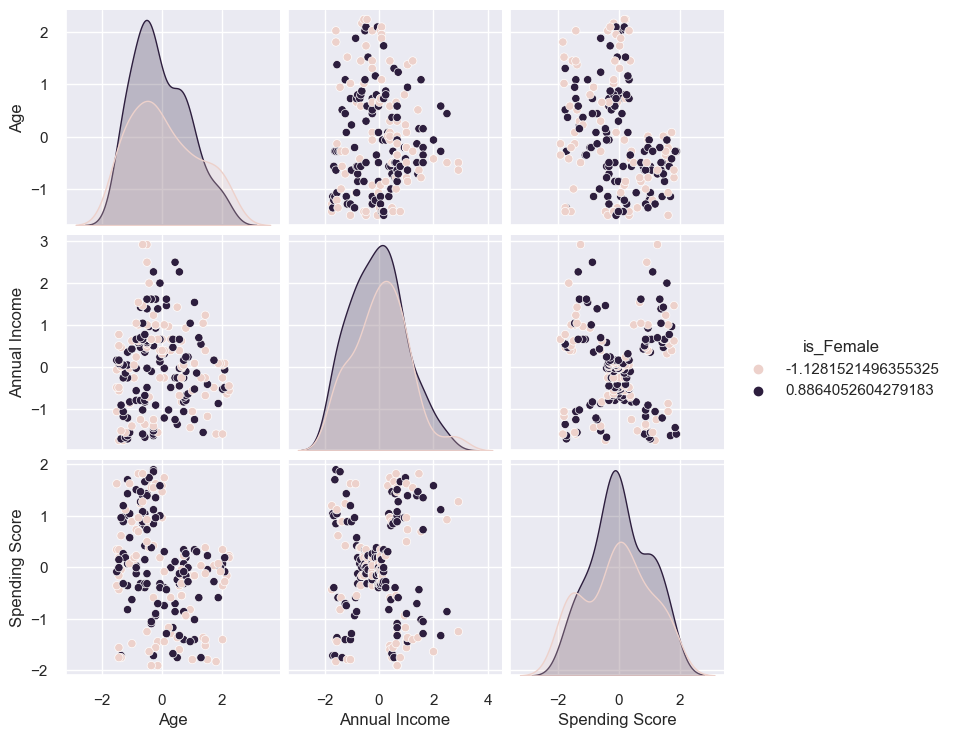

In [13]:
sns.pairplot(data=data_transformed, hue='is_Female')
plt.show(sns)

Посмотрим, есть ли корреляция между признаками.

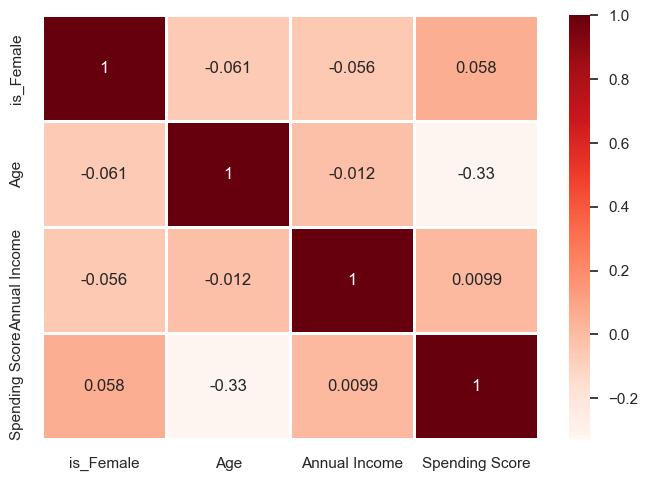

In [14]:
# корреляция
sns.heatmap(data_transformed.corr(), annot=True, linewidth=.8, cmap="Reds")
plt.show(sns)

Присутствует умеренная отрицательная корреляция между параметрами 'Age' и 'Spending Score'.

Признаки стандартизированы, поэтому матрица ковариации будет идентична матрице корреляции.

In [ ]:
# # ковариация
# sns.heatmap(data_transformed.cov(), annot=True, linewidth=.8, cmap="Reds")

# Clustering without feature optimization

## K-means

Для кластеризации методом kmeans (и некоторых других методов) необходимо предположение о количестве кластеров.

Для определения оптимального количества для kmeans применяют:
* метод локтя (wcss - within-cluster sum of squares или сумма квадратов внутрикластерных расстояний)
* метод силуэта (коэф. силуэта)

**WCSS** - рассчитывается как сумма квадратов расстояний от каждой точки данных до центроида её кластера. Выбираем значение, на котором WCSS перестанет существенно уменьшаться.

**Коэф. силуэта** вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу. Формула: (b - a) / max(a, b). Выбираем значение на пике.

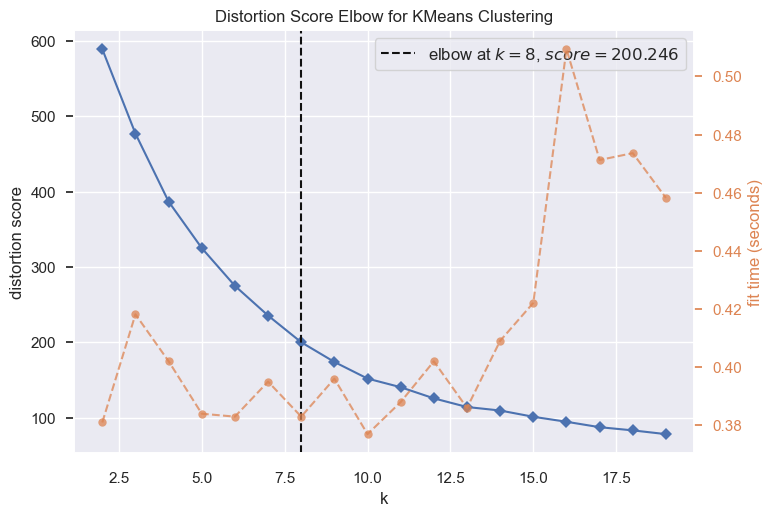

Wall time: 0 ns


In [18]:
# KElbowVisualizer
get_cluster_num(max_clusters=20, X=X)

  0%|          | 0/18 [00:00<?, ?it/s]

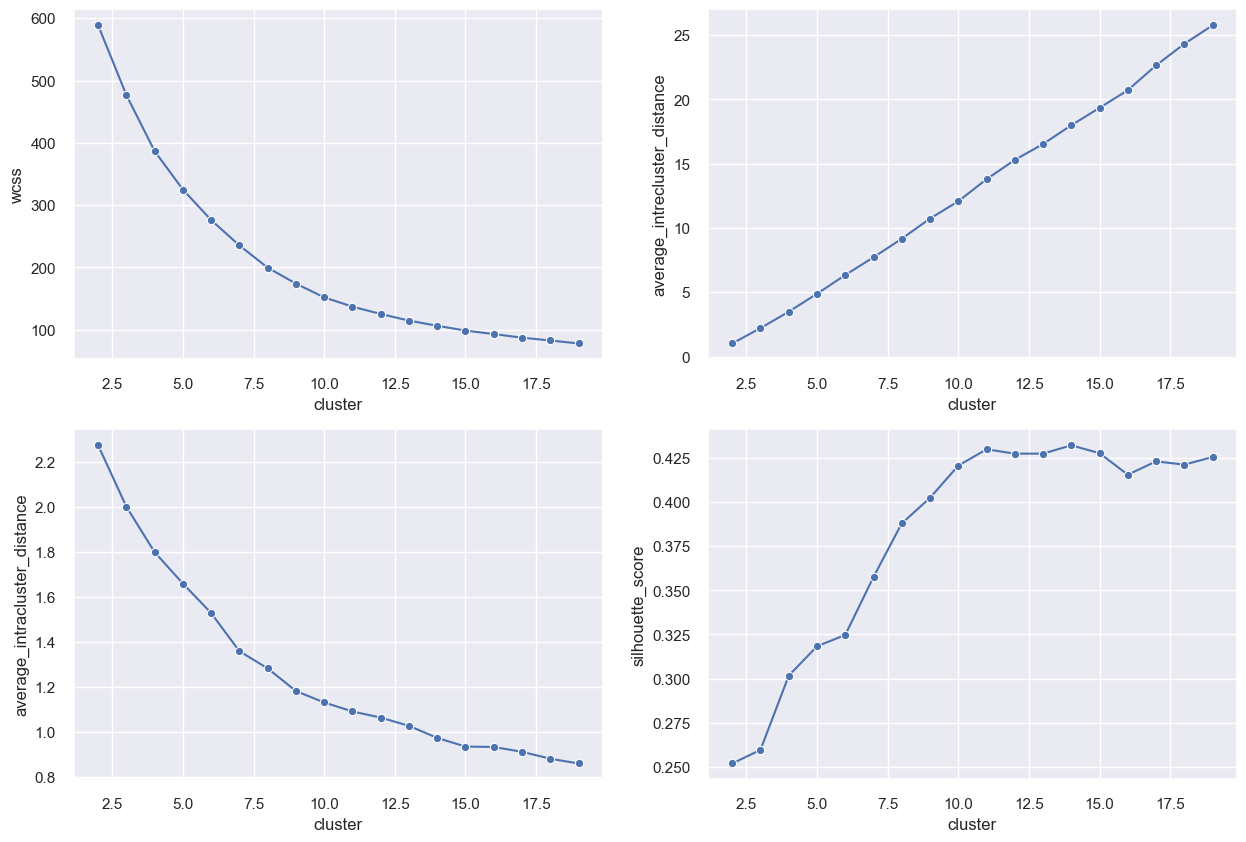

Wall time: 0 ns


In [26]:
# Реализация метода локтя (вручную) и
# Если init='k-means++' то центроиды кластеров с самого начала располагаются 
#     максимально далеко друг от друга

wcss, aed, aad, ss = [], [], [], []
carry = X

for n_clusters in tqdm(range(2, 20)):
    # инициализация и обучение модели
    model = KMeans(n_clusters=n_clusters, init='k-means++',
                    max_iter=500, n_init=30, random_state=RANDOM_STATE)
    model.fit(carry)
    # для каждого кластера рассчитаем ошибку wcss (атрибут inertia_),
      #  среднюю межкластерную и внутриклатерную дистанцию, силуэтный коэффициент
    wcss.append([n_clusters, model.inertia_])
    aed.append([n_clusters, average_intrecluster_distance(model.cluster_centers_)])
    aad.append([n_clusters, average_intracluster_distance(carry, model.labels_)])
    ss.append([n_clusters, silhouette_score(carry, model.labels_)])

wcss = pd.DataFrame(wcss, columns=['cluster', 'wcss'])
aed = pd.DataFrame(aed, columns=['cluster', 'average_intrecluster_distance'])
aad = pd.DataFrame(aad, columns=['cluster', 'average_intracluster_distance'])
ss = pd.DataFrame(ss, columns=['cluster', 'silhouette_score'])

# визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.lineplot(ax=axes[0, 0], data=wcss, x='cluster', y='wcss', marker='o')
sns.lineplot(ax=axes[0, 1], data=aed, x='cluster', y='average_intrecluster_distance', marker='o')
sns.lineplot(ax=axes[1, 0], data=aad, x='cluster', y='average_intracluster_distance', marker='o')
sns.lineplot(ax=axes[1, 1], data=ss, x='cluster', y='silhouette_score', marker='o')
plt.show()

del wcss, aed, aad, ss, carry, model

Оптимальное колво кластеров 10-11. Но я хочу более точечные кластеры, поэтому возьму больше - 15.

In [21]:
n_clusters = 15
carry = X

# инициализируем и обучаем модель с выбранными гипепараметрами
kmeans = KMeans(n_clusters=n_clusters, init='k-means++',
                max_iter=500, n_init=30, random_state=RANDOM_STATE)
kmeans.fit(carry)
data['kmeans'] = kmeans.labels_

kmeans_metrics = {
    'n_clusters': n_clusters,
    'wcss': kmeans.inertia_, # Сумма квадратов внутрикластерных расстояний
    'n_iter_': kmeans.n_iter_, # Кол-во итераций модели до сходимости алгоритма
    'n_features_in_': kmeans.n_features_in_, # Кол-во параметров
    'average_intrecluster_distance': average_intrecluster_distance(kmeans.cluster_centers_), # Среднее межкластерное растояние
    'average_intracluster_distance': average_intracluster_distance(carry, kmeans.labels_), # Среднее внутрикластерное растояние
    'silhouette_score': silhouette_score(carry, kmeans.labels_) # Cилуэтный коэффициент
}

del n_clusters, carry

print_metrics(kmeans_metrics)

n_clusters = 15
wcss = 98.71784334213683
n_iter_ = 7
n_features_in_ = 4
average_intrecluster_distance = 19.345868637485257
average_intracluster_distance = 0.9354161670174829
silhouette_score = 0.42783294875662037


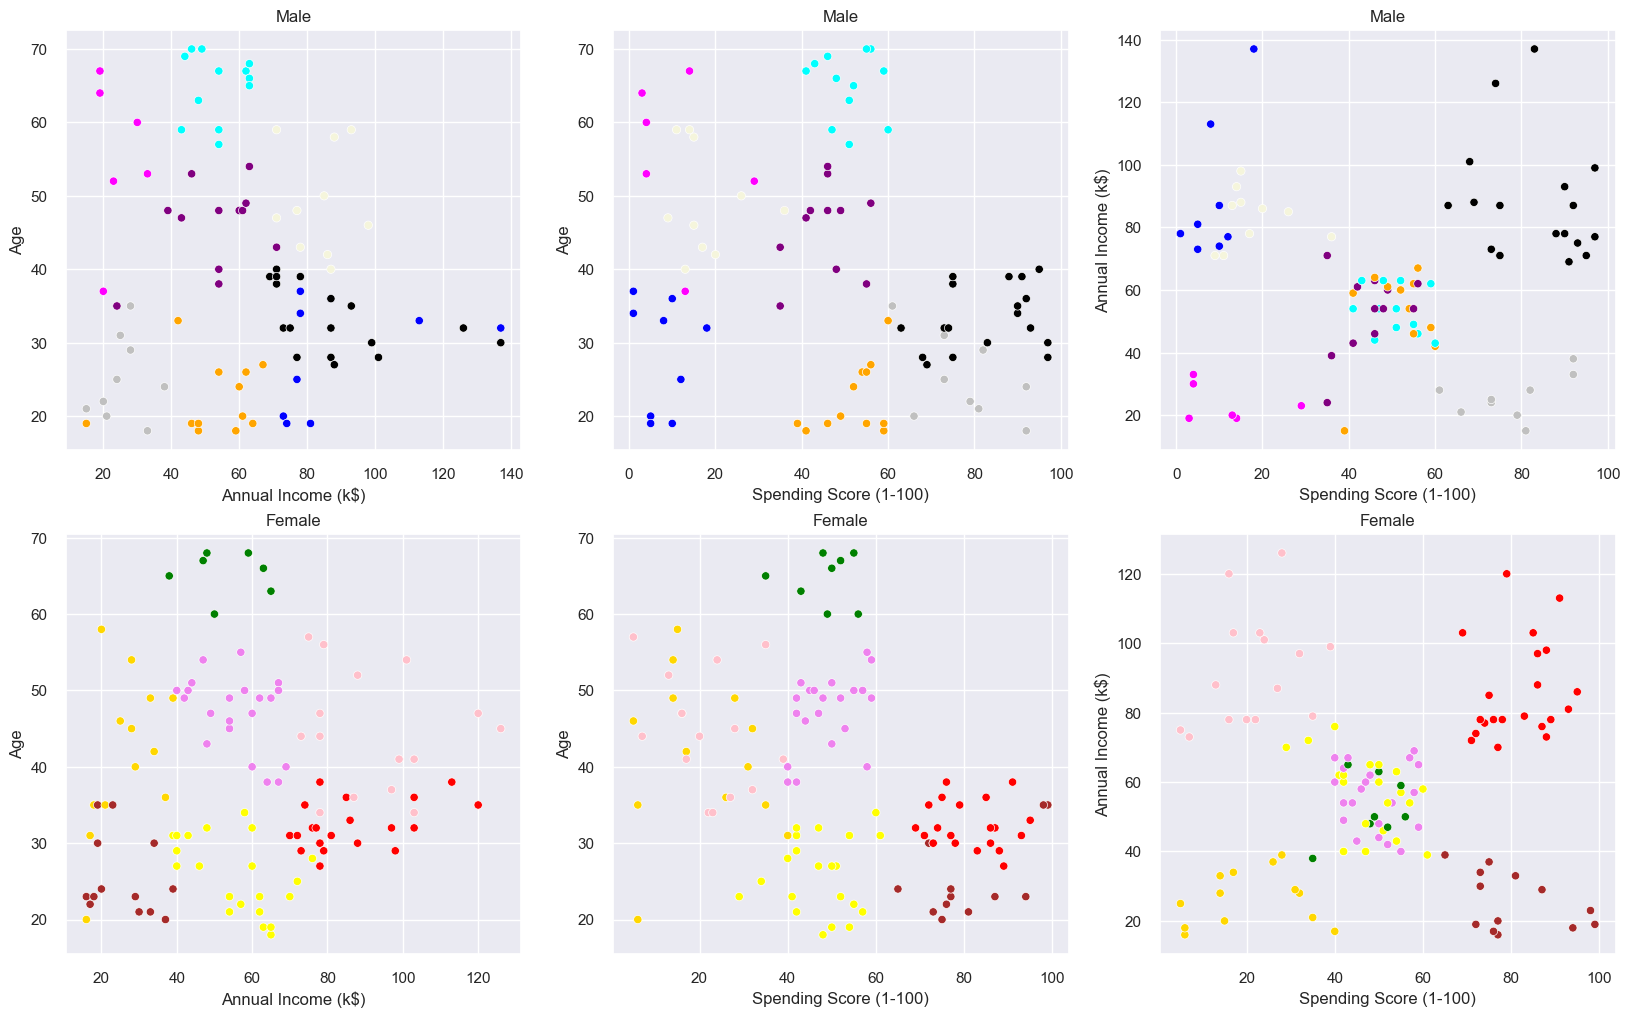

In [24]:
visualization_2d(data=data, col='kmeans', cols=data.columns[1:], labels={
        'x': ['Annual Income (k$)', 'Spending Score (1-100)', 'Spending Score (1-100)'],
        'y': ['Age', 'Age', 'Annual Income (k$)']
})

plt.show()

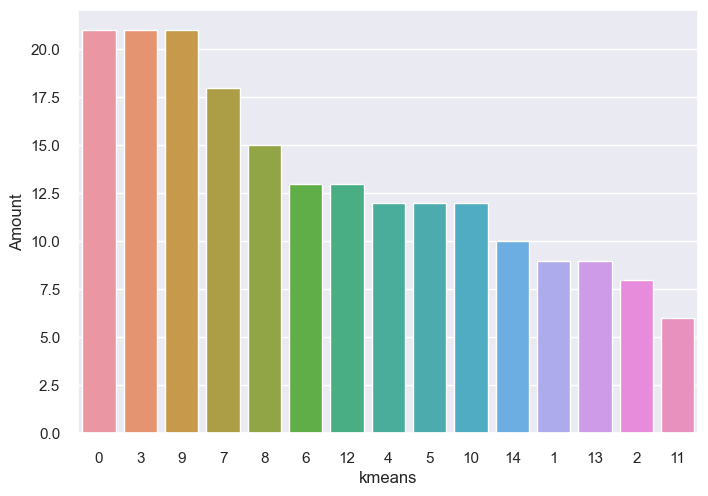

In [28]:
barplot_of_cluster_size(data, 'kmeans')

In [29]:
info_by_cluster(data, 'kmeans')

Age                   Annual Income (k$)         \
                 count       mean median               mean median   
kmeans is_Female                                                     
0      1            21  32.190476   32.0          86.047619   79.0   
1      0             9  28.333333   32.0          88.666667   78.0   
2      1             8  64.625000   65.5          52.500000   50.0   
3      1            21  25.857143   27.0          55.904762   58.0   
4      0            12  22.333333   19.5          52.166667   56.5   
5      0            12  45.916667   48.0          52.583333   54.0   
6      1            13  25.461538   23.0          25.692308   23.0   
7      0            18  33.277778   32.0          87.111111   82.5   
8      1            15  44.600000   44.0          92.333333   88.0   
9      1            21  47.190476   49.0          55.761905   57.0   
10     0            12  65.000000   66.5          53.583333   54.0   
11     0             6  55.500000   56.5          24.000000   21.5   
12     1            13  41.538462   42.0          26.538462   28.0   
13     0             9  25.000000   24.0          25.777778   25.0   
14     0            10  49.200000   47.5          83.400000   85.5   

                 Spending Score (1-100)         
                                   mean median  
kmeans is_Female                                
0      1                      81.666667   83.0  
1      0                       7.777778    8.0  
2      1                      48.500000   49.5  
3      1                      47.523810   48.0  
4      0                      52.083333   54.5  
5      0                      44.583333   46.0  
6      1                      80.538462   77.0  
7      0                      82.666667   85.5  
8      1                      21.600000   22.0  
9      1                      49.047619   48.0  
10     0                      50.750000   51.0  
11     0                      11.166667    8.5  
12     1                      20.692308   17.0  
13     0                      77.666667   79.0  
14     0                      17.600000   15.0

## MeanShift

* не требует предварительного указания числа кластеров
* можно детекритовать выбросы

Важные параметры:
* bandwidth - радиус области (те ядро), который используется наблюдением для определения направления сдвига.
* ciuster_all=False - если точка не попадает в ядро, то она опеределяется как выброс (-1)
* bin_seeding (true/false) - если false, то в качестве начальных ядер выступают точки; если true, то точки объединяются в сетку, где ширина ячейки зависит от значения bandwidth, и эта ячейка определяется как ядро (ускоряет работу алгоритма)
* min_bin_freq - минимальное количество точек данных, которое должно присутствовать в ячейке сетки для того, чтобы она была использована как начальное ядро

  0%|          | 0/19 [00:00<?, ?it/s]

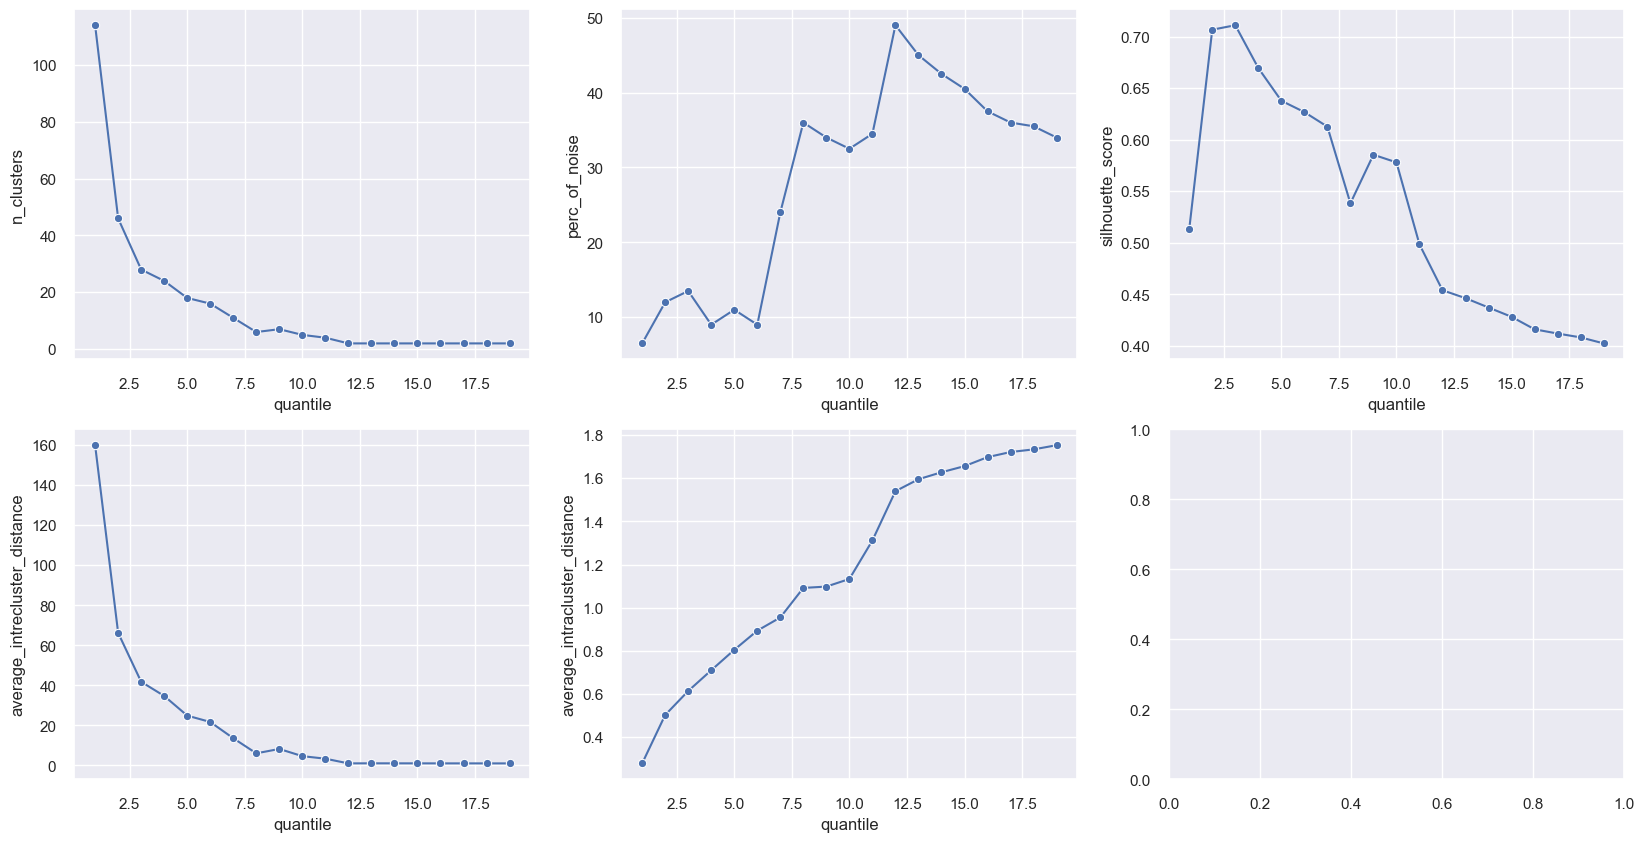

In [30]:
# quantile - should be between [0, 1] 0.5 means that the median of all pairwise distances is used


# bandwidth=None - пропускная способность ядра оценивается с помощью sklearn.cluster.estimate_bandwidth
#   sklearn.cluster.estimate_bandwidth рассчитывает пропускную способность на основе метода ближайших соседей
# seeds=None - начальные ядра не указаны, поэтому используются все данные в качестве начальных ядер
# bin_seeding=False - используем каждую точку данных, а не сетку
# cluster_all=False - помячаем выбросы


nc, pn, ss, aed, aad = [], [], [], [], []
carry = data_transformed

for quantile in tqdm(range(1, 20, 1)): # 1: (5, 80, 5) --> 2: (2, 20, 1)
    # опеределение параматра bandwidth для модели
    bandwidth = estimate_bandwidth(carry, quantile=round(quantile/100, 2),
                                   random_state=RANDOM_STATE)

    # инициализация и обучение модели
    model = MeanShift(bandwidth=bandwidth, seeds=None,
            bin_seeding=True, min_bin_freq=1,
            cluster_all=False, n_jobs=-1, max_iter=500)
    model.fit(carry)

    df = carry.copy()
    df['pred'] = model.labels_
    df = df[df.pred > -1]

    # для каждого кластера рассчитаем силуэтный коэффициент,
    #     среднюю межкластерную и внутриклатерную дистанцию
    try:
        nc.append([quantile, df.pred.nunique()])
        pn.append([quantile, ( (model.labels_ == -1).sum() / model.labels_.shape[0] ) * 100 ])
        aed.append([quantile, average_intrecluster_distance(model.cluster_centers_)])
        aad.append([quantile, average_intracluster_distance(df, df.pred)])
        ss.append([quantile, silhouette_score(df, df.pred)]) # ValueError
    except ValueError as vr:
        print('Error caught: {}'.format(vr))
        continue


nc = pd.DataFrame(nc, columns=['quantile', 'n_clusters'])
pn = pd.DataFrame(pn, columns=['quantile', 'perc_of_noise'])
ss = pd.DataFrame(ss, columns=['quantile', 'silhouette_score'])
aed = pd.DataFrame(aed, columns=['quantile', 'average_intrecluster_distance'])
aad = pd.DataFrame(aad, columns=['quantile', 'average_intracluster_distance'])

# визуализация
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
sns.lineplot(ax=axes[0, 0], data=nc, x='quantile', y='n_clusters', marker='o')
sns.lineplot(ax=axes[0, 1], data=pn, x='quantile', y='perc_of_noise', marker='o')
sns.lineplot(ax=axes[0, 2], data=ss, x='quantile', y='silhouette_score', marker='o')
sns.lineplot(ax=axes[1, 0], data=aed, x='quantile', y='average_intrecluster_distance', marker='o')
sns.lineplot(ax=axes[1, 1], data=aad, x='quantile', y='average_intracluster_distance', marker='o')
plt.show()

del nc, pn, aed, aad, ss, carry, model, df

На первом этапе (где range(5, 80, 5)) было определено, что на значении quantile=0.2 межкластерное расстояние = 0, то есть определяется только 1 кластер. Далее, детализарует диапазон [0.01-0.2) шагом 0.01.

Дальше пойдет значение 0.06-0.07 --> bandwidth=0.065, так, если больше, то уже высокий процент шума

In [31]:
quantile = 0.065
carry = data_transformed.copy()

# опеределение параматра bandwidth для модели
bandwidth = estimate_bandwidth(carry, quantile=quantile,
                                random_state=RANDOM_STATE)

# инициализация и обучение модели
ms = MeanShift(bandwidth=bandwidth, seeds=None,
        bin_seeding=False, # min_bin_freq=1,
        cluster_all=False, n_jobs=-1, max_iter=500)
ms.fit(carry)
data['meanshift'], carry['meanshift'] = ms.labels_, ms.labels_

carry = carry[carry.meanshift > -1]

ms_metrics = {
    'n_clusters': np.max(ms.labels_) + 1,
    'n_iter_': ms.n_iter_, # Кол-во итераций модели до сходимости алгоритма
    'n_features_in_': ms.n_features_in_, # Кол-во параметров
    'perc_of_noise': ( (ms.labels_ == -1).sum() / ms.labels_.shape[0] ) * 100,
    'average_intrecluster_distance': average_intrecluster_distance(ms.cluster_centers_), # Среднее межкластерное растояние
    'average_intracluster_distance': average_intracluster_distance(carry, carry.meanshift), # Среднее внутрикластерное растояние
    'silhouette_score': silhouette_score(carry, carry.meanshift) # Cилуэтный коэффициент
}

del quantile, carry

print_metrics(ms_metrics)

n_clusters = 15
n_iter_ = 10
n_features_in_ = 4
perc_of_noise = 14.499999999999998
average_intrecluster_distance = 20.12106976848629
average_intracluster_distance = 0.9447695082397635
silhouette_score = 0.6448984070615622


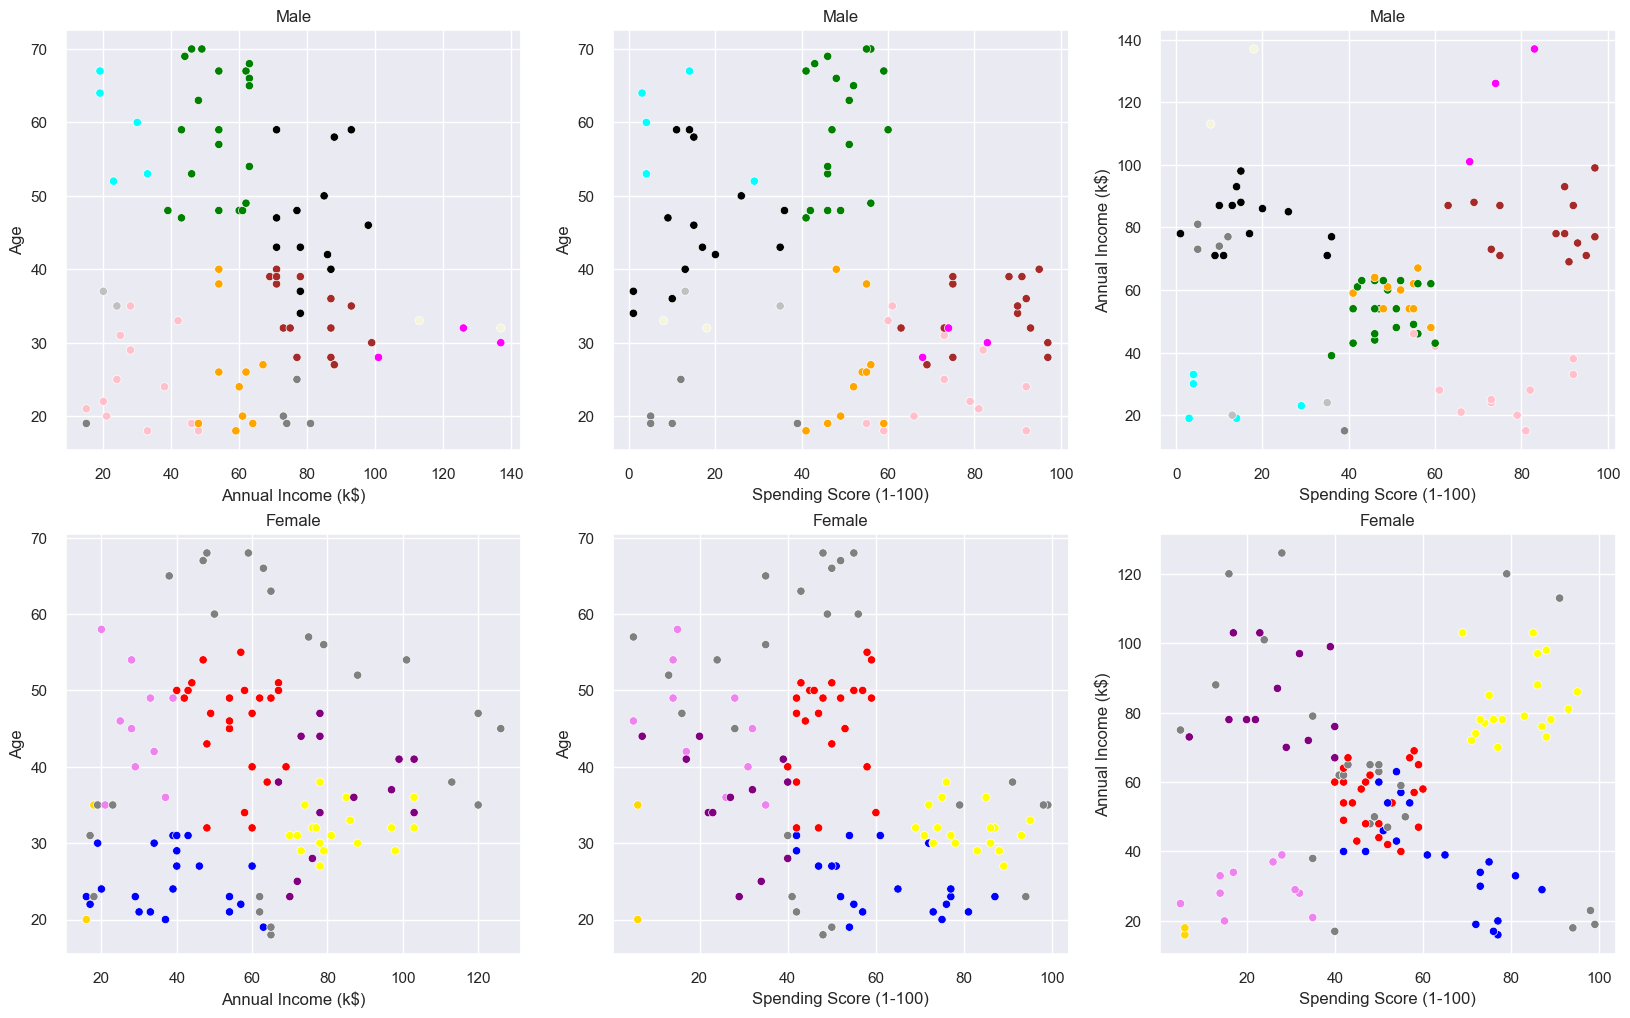

In [32]:
visualization_2d(data=data, col='meanshift', cols=data.columns[1:], labels={
        'x': ['Annual Income (k$)', 'Spending Score (1-100)', 'Spending Score (1-100)'],
        'y': ['Age', 'Age', 'Annual Income (k$)']
})

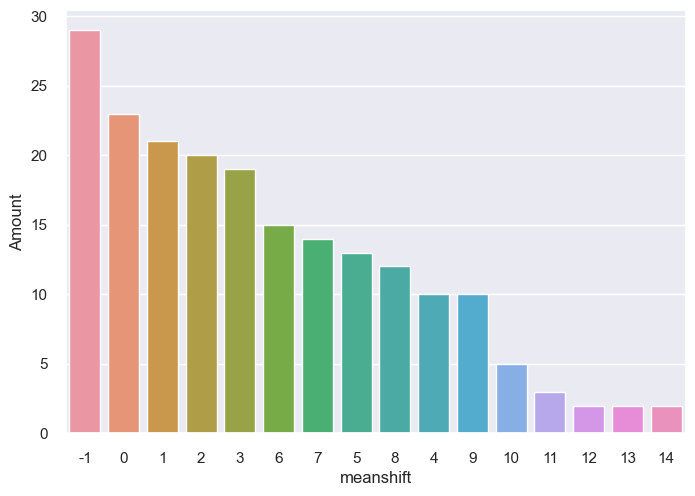

In [33]:
barplot_of_cluster_size(data, 'meanshift')

In [34]:
info_by_cluster(data, 'meanshift')

Age                   Annual Income (k$)         \
                    count       mean median               mean median   
meanshift is_Female                                                     
-1        0             5  20.400000   19.0          64.000000   74.0   
          1            24  46.083333   49.5          65.541667   62.5   
 0        1            23  45.695652   49.0          55.217391   57.0   
 1        1            21  25.047619   24.0          38.571429   39.0   
 2        0            20  58.750000   59.0          53.550000   54.0   
 3        1            19  31.736842   31.0          82.842105   78.0   
 4        0            10  25.700000   25.0          58.300000   59.5   
 5        1            13  36.307692   37.0          83.153846   78.0   
 6        0            15  33.933333   34.0          80.266667   78.0   
 7        0            14  45.857143   44.5          82.000000   81.5   
 8        0            12  24.583333   23.0          30.666667   28.0   
 9        1            10  45.400000   45.5          29.400000   28.5   
 10       0             5  59.200000   60.0          24.800000   23.0   
 11       0             3  30.000000   30.0         121.333333  126.0   
 12       1             2  27.500000   27.5          17.000000   17.0   
 13       0             2  36.000000   36.0          22.000000   22.0   
 14       0             2  32.500000   32.5         125.000000  125.0   

                    Spending Score (1-100)         
                                      mean median  
meanshift is_Female                                
-1        0                      14.200000   10.0  
          1                      49.625000   48.0  
 0        1                      49.521739   48.0  
 1        1                      62.904762   61.0  
 2        0                      48.550000   47.5  
 3        1                      81.315789   83.0  
 4        0                      51.500000   53.0  
 5        1                      26.615385   27.0  
 6        0                      84.200000   90.0  
 7        0                      15.928571   14.5  
 8        0                      72.750000   73.0  
 9        1                      21.700000   21.5  
 10       0                      10.800000    4.0  
 11       0                      75.000000   74.0  
 12       1                       6.000000    6.0  
 13       0                      24.000000   24.0  
 14       0                      13.000000   13.0

## Agglomerative Clustering

Важные параметры:
* linkage - определяет стратегию слияния / критерий связи / какое расстояние использовать между наборами наблюдений
  - 'ward': минимизация дисперсии в кластере, минимизирует сумму квадратов разностей во всех кластерах. Использует евклидово расстояние. Близко к kmeans
  - 'average': минимизирует среднее расстояние между всеми наблюдениями пар кластеров
  - 'complete': сводит к минимуму максимальное расстояние между наблюдениями пар кластеров
  - 'single': минимизирует расстояние между ближайшими наблюдениями пар кластеров
* affinity - параметр близости, определяет метрический показатель расстояния, используемый для параметра linkage (minkowski, euclidean и тд).
* n_clusters - кол-во кластеров, которые кластеризующий алгоритм будет пытаться найти

In [35]:
n_clusters = 15
carry = X

agglom = AgglomerativeClustering(n_clusters=n_clusters, compute_distances=False,
                                 affinity='euclidean', linkage='ward') # ward or average
agglom.fit(carry)
data['agglomerative'] = agglom.labels_

agglom_metrics = {
    'n_clusters': n_clusters,
    'n_features_in_': agglom.n_features_in_, # Кол-во параметров
    'average_intracluster_distance': average_intracluster_distance(carry, agglom.labels_), # Среднее внутрикластерное растояние
    'silhouette_score': silhouette_score(carry, agglom.labels_) # Cилуэтный коэффициент
}

del n_clusters, carry

print_metrics(agglom_metrics)

n_clusters = 15
n_features_in_ = 4
average_intracluster_distance = 0.9647779785488458
silhouette_score = 0.4344600643875798


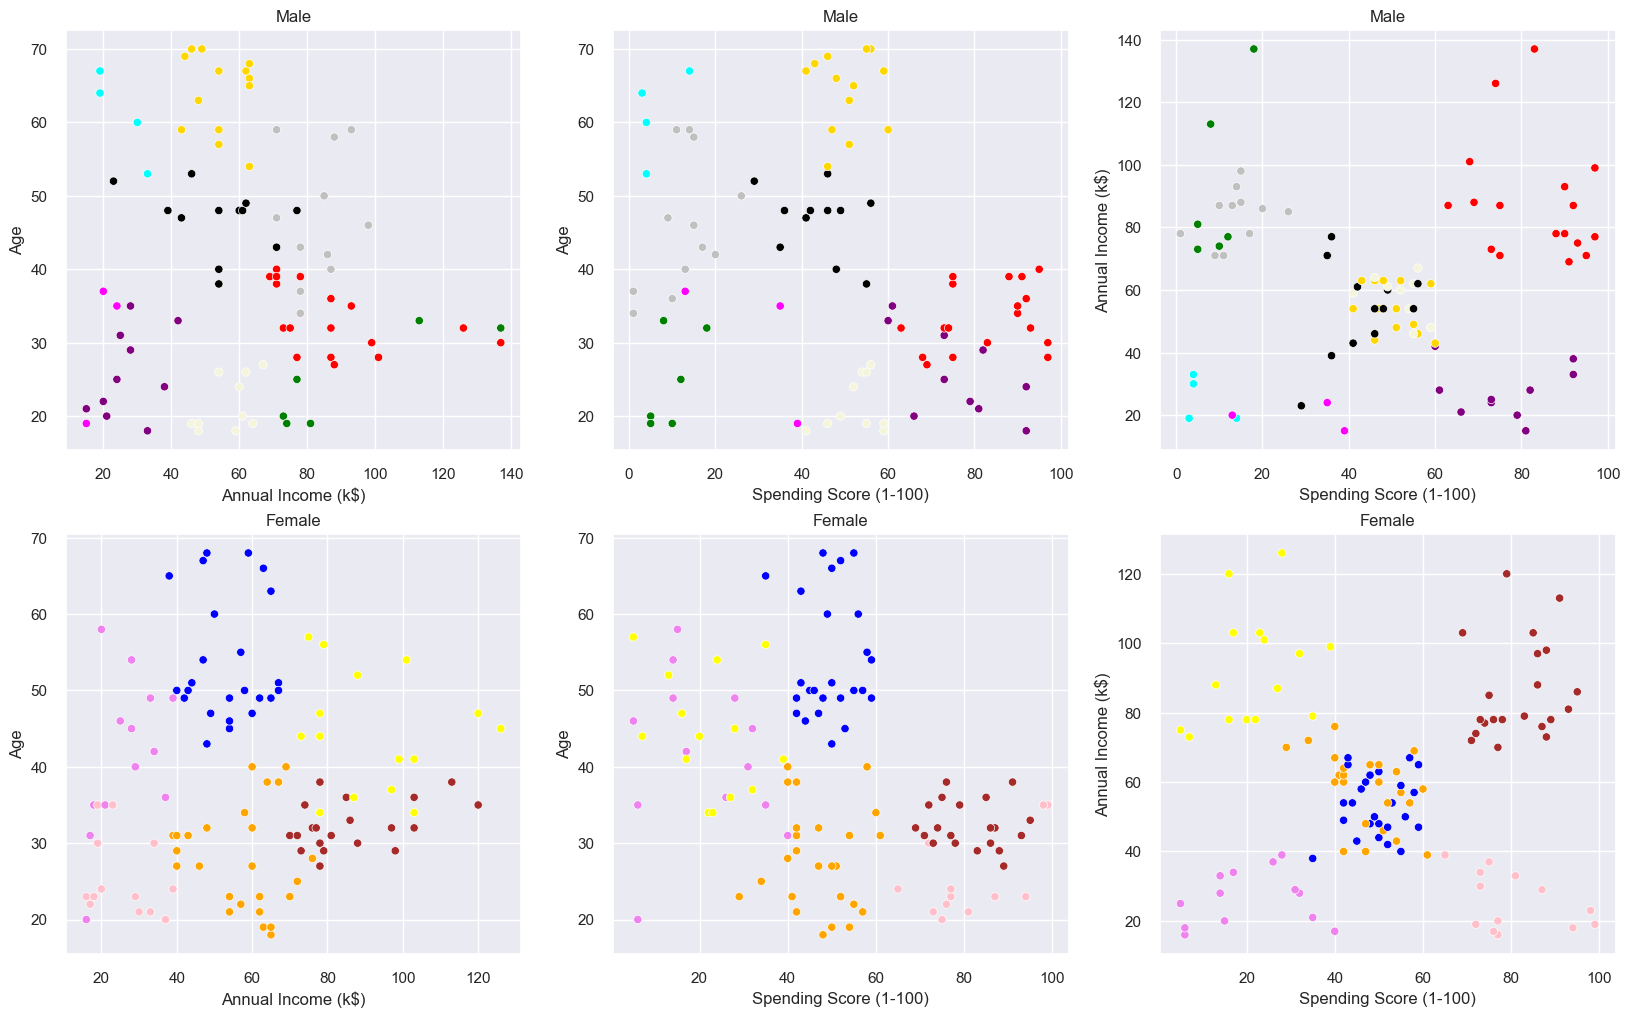

In [36]:
visualization_2d(data=data, col='agglomerative', cols=data.columns[1:], labels={
        'x': ['Annual Income (k$)', 'Spending Score (1-100)', 'Spending Score (1-100)'],
        'y': ['Age', 'Age', 'Annual Income (k$)']
})

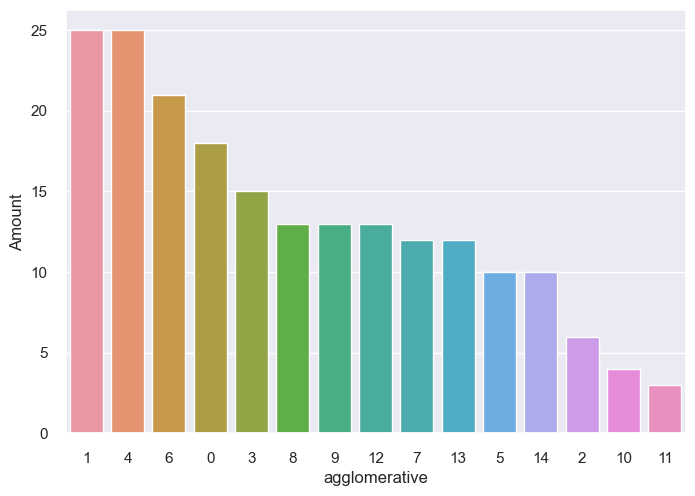

In [37]:
barplot_of_cluster_size(data, 'agglomerative')

In [38]:
info_by_cluster(data, 'agglomerative')

Age                   Annual Income (k$)         \
                        count       mean median               mean median   
agglomerative is_Female                                                     
0             0            18  33.277778   32.0          87.111111   82.5   
1             1            25  54.080000   50.0          53.240000   54.0   
2             0             6  24.666667   22.5          92.500000   79.0   
3             1            15  44.600000   44.0          92.333333   88.0   
4             1            25  27.960000   27.0          57.360000   60.0   
5             0            10  25.800000   24.5          27.400000   26.5   
6             1            21  32.190476   32.0          86.047619   79.0   
7             0            12  46.833333   48.0          53.666667   54.0   
8             1            13  25.461538   23.0          25.692308   23.0   
9             1            13  41.538462   42.0          26.538462   28.0   
10            0             4  61.000000   62.0          25.250000   24.5   
11            0             3  30.333333   35.0          19.666667   20.0   
12            0            13  64.153846   66.0          54.307692   54.0   
13            0            12  45.916667   44.5          83.333333   85.5   
14            0            10  21.600000   19.5          56.900000   59.5   

                        Spending Score (1-100)         
                                          mean median  
agglomerative is_Female                                
0             0                      82.666667   85.5  
1             1                      49.520000   50.0  
2             0                       9.666667    9.0  
3             1                      21.600000   22.0  
4             1                      47.120000   47.0  
5             0                      75.900000   76.0  
6             1                      81.666667   83.0  
7             0                      43.250000   44.0  
8             1                      80.538462   77.0  
9             1                      20.692308   17.0  
10            0                       6.250000    4.0  
11            0                      29.000000   35.0  
12            0                      50.384615   51.0  
13            0                      12.666667   13.5  
14            0                      52.600000   54.5

## HDBSCAN
* cant update notebook to 1.3.0

Hierarchical Density-Based Spatial Clustering of Applications with Noise - является улучшением алгоритма DBSCAN. Он основан на плотностной кластеризации, но, в отличие от DBSCAN, может обнаруживать кластеры различной плотности.

Основной параметр для настройки:
* min_cluster_size - минимальное количество точек для определения кластера. Если группа точек меньше этого значения, то группа будет считаться шумом
* min_samples - определяет, сколько образцов должно быть в окрестности заданной точки, чтобы она считалась "центральной" точкой кластера (вкл. центральную точку)
* cluster_selection_epsilon - порог расстояния между кластерами
* cluster_selection_method
  - leaf выбирает все листовые кластеры без какой-либо дополнительной обработки. подход может создать большое количество мелких кластеров, некоторые из которых могут быть менее стабильными или менее интересными с практической точки зрения.
  - eom выделяет кластеры, которые стабильны на различных масштабах плотности. кластеры получаются более стабильными.
* max_cluster_size - лимит для размера кластера, если cluster_selection_method='eom'
* metric - указывается способ вычисления дистанции между точками, например, 'euclidean'
* alpha - "робость" опеределения шума, default=1
* store_centers - вычисление центра кластера, default=None
  - 'centroid' - представляет собой взвешенное среднее положения точек в кластере, может не совпадать с реальной точкой
  - 'medoid' - реальная точка из ваших данных, которая минимизирует расстояние до всех других точек в кластере. рассчитывается медленнее
  - 'both'

Если нужны более крупные, стабильные кластеры, то EOM. Если необходимо получить максимально детальное разбиение данных на мелкие кластеры, то Leaf может быть предпочтительне.

  0%|          | 0/21 [00:00<?, ?it/s]

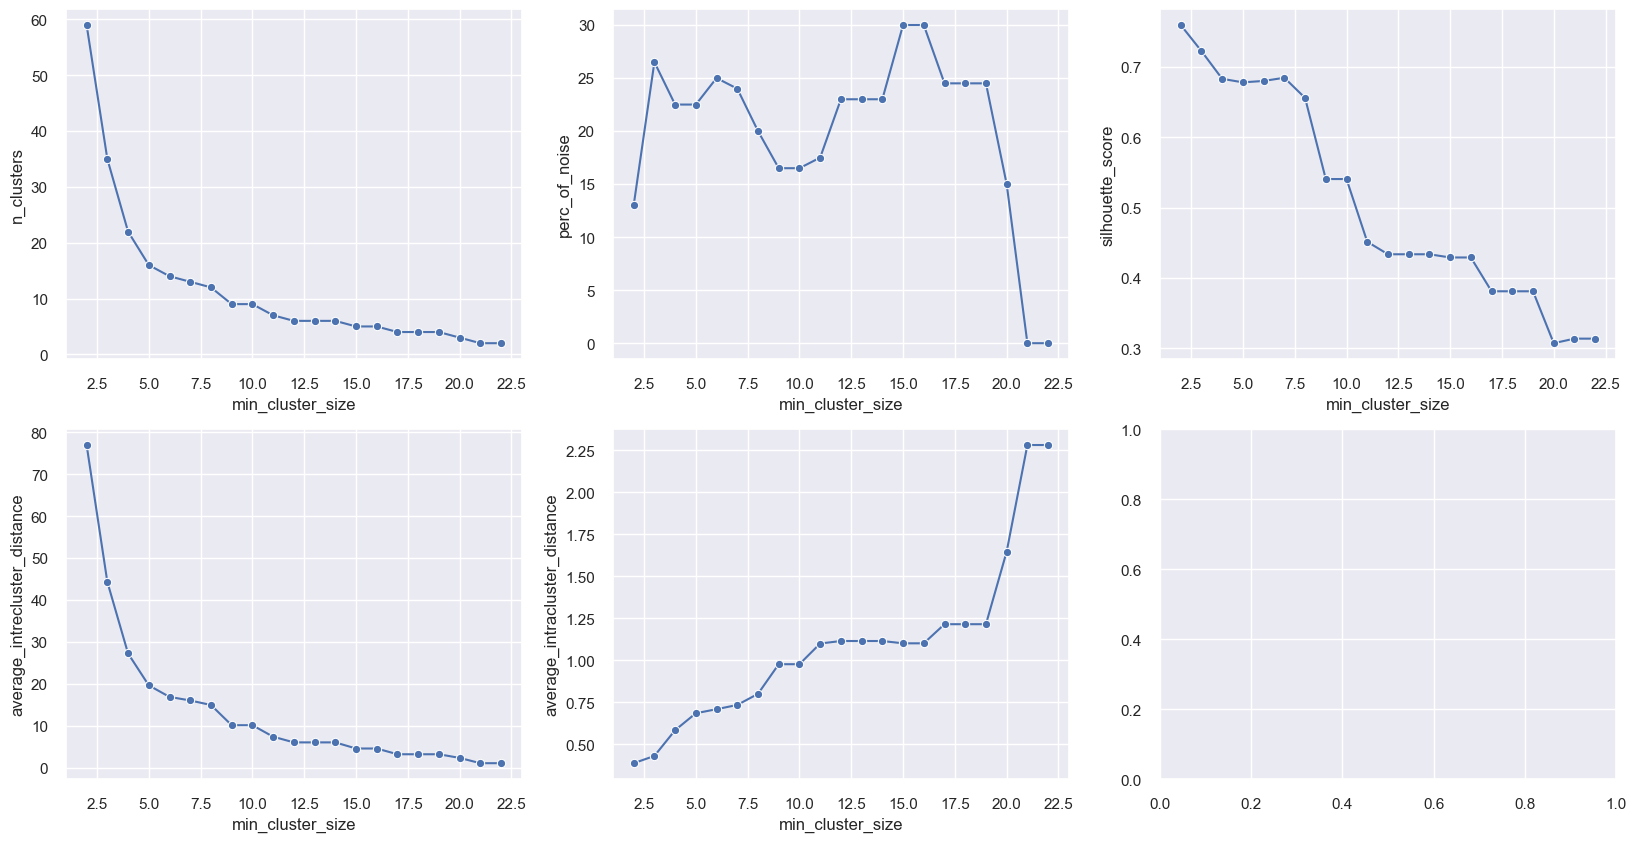

In [39]:
nc, pn, aed, aad, ss = [], [], [], [], []
carry = data_transformed

for min_cluster_size in tqdm(range(2, 23)):
    model = HDBSCAN(min_cluster_size=min_cluster_size, alpha=.25, # min_samples == min_cluster_size
                        metric='euclidean', cluster_selection_method='leaf',
                        store_centers='medoid', n_jobs=-1)
    model.fit(carry)

    df = carry.copy()
    df['hdbscan'] = model.labels_
    df = df[df['hdbscan'] > -1]

    try:
        nc.append([min_cluster_size, np.max(model.labels_) + 1])
        pn.append([min_cluster_size, ( (model.labels_ == -1).sum() / model.labels_.shape[0] ) * 100])
        aed.append([min_cluster_size, average_intrecluster_distance(model.medoids_)])
        aad.append([min_cluster_size, average_intracluster_distance(df, df['hdbscan'])])
        ss.append([min_cluster_size, silhouette_score(df, df['hdbscan'])]) # ValueError
    except ValueError as vr:
        print('Error caught: {}'.format(vr))
        continue


nc = pd.DataFrame(nc, columns=['min_cluster_size', 'n_clusters'])
pn = pd.DataFrame(pn, columns=['min_cluster_size', 'perc_of_noise'])
aed = pd.DataFrame(aed, columns=['min_cluster_size', 'average_intrecluster_distance'])
aad = pd.DataFrame(aad, columns=['min_cluster_size', 'average_intracluster_distance'])
ss = pd.DataFrame(ss, columns=['min_cluster_size', 'silhouette_score'])

# визуализация
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
sns.lineplot(ax=axes[0, 0], data=nc, x='min_cluster_size', y='n_clusters', marker='o')
sns.lineplot(ax=axes[0, 1], data=pn, x='min_cluster_size', y='perc_of_noise', marker='o')
sns.lineplot(ax=axes[0, 2], data=ss, x='min_cluster_size', y='silhouette_score', marker='o')
sns.lineplot(ax=axes[1, 0], data=aed, x='min_cluster_size', y='average_intrecluster_distance', marker='o')
sns.lineplot(ax=axes[1, 1], data=aad, x='min_cluster_size', y='average_intracluster_distance', marker='o')
plt.show()

del nc, pn, aed, aad, ss, carry, model, df

min_cluster_size = 5 выглядит неплохо. возьму его

In [40]:
min_cluster_size = 5
df = data_transformed.copy()

hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, alpha=.25, # min_samples == min_cluster_size
                    metric='euclidean', cluster_selection_method='leaf',
                    store_centers='medoid', n_jobs=-1)
hdbscan.fit(X)
data['hdbscan'], df['hdbscan'] = hdbscan.labels_, hdbscan.labels_

df = df[df['hdbscan'] > -1]

hdbscan_metrics = {
    'n_clusters': np.max(hdbscan.labels_) + 1,
    'perc_of_noise': ( (hdbscan.labels_ == -1).sum() / hdbscan.labels_.shape[0] ) * 100,
    'n_features_in_': hdbscan.n_features_in_, # Кол-во параметров
    'average_intrecluster_distance': average_intrecluster_distance(hdbscan.medoids_), # Среднее межкластерное растояние
    'average_intracluster_distance': average_intracluster_distance(df, df['hdbscan']), # Среднее внутрикластерное растояние
    'silhouette_score': silhouette_score(df, df['hdbscan']) # Cилуэтный коэффициент
}

print_metrics(hdbscan_metrics)

del min_cluster_size, df

n_clusters = 16
perc_of_noise = 22.5
n_features_in_ = 4
average_intrecluster_distance = 19.628667459062743
average_intracluster_distance = 0.683775923505274
silhouette_score = 0.6780814356719612


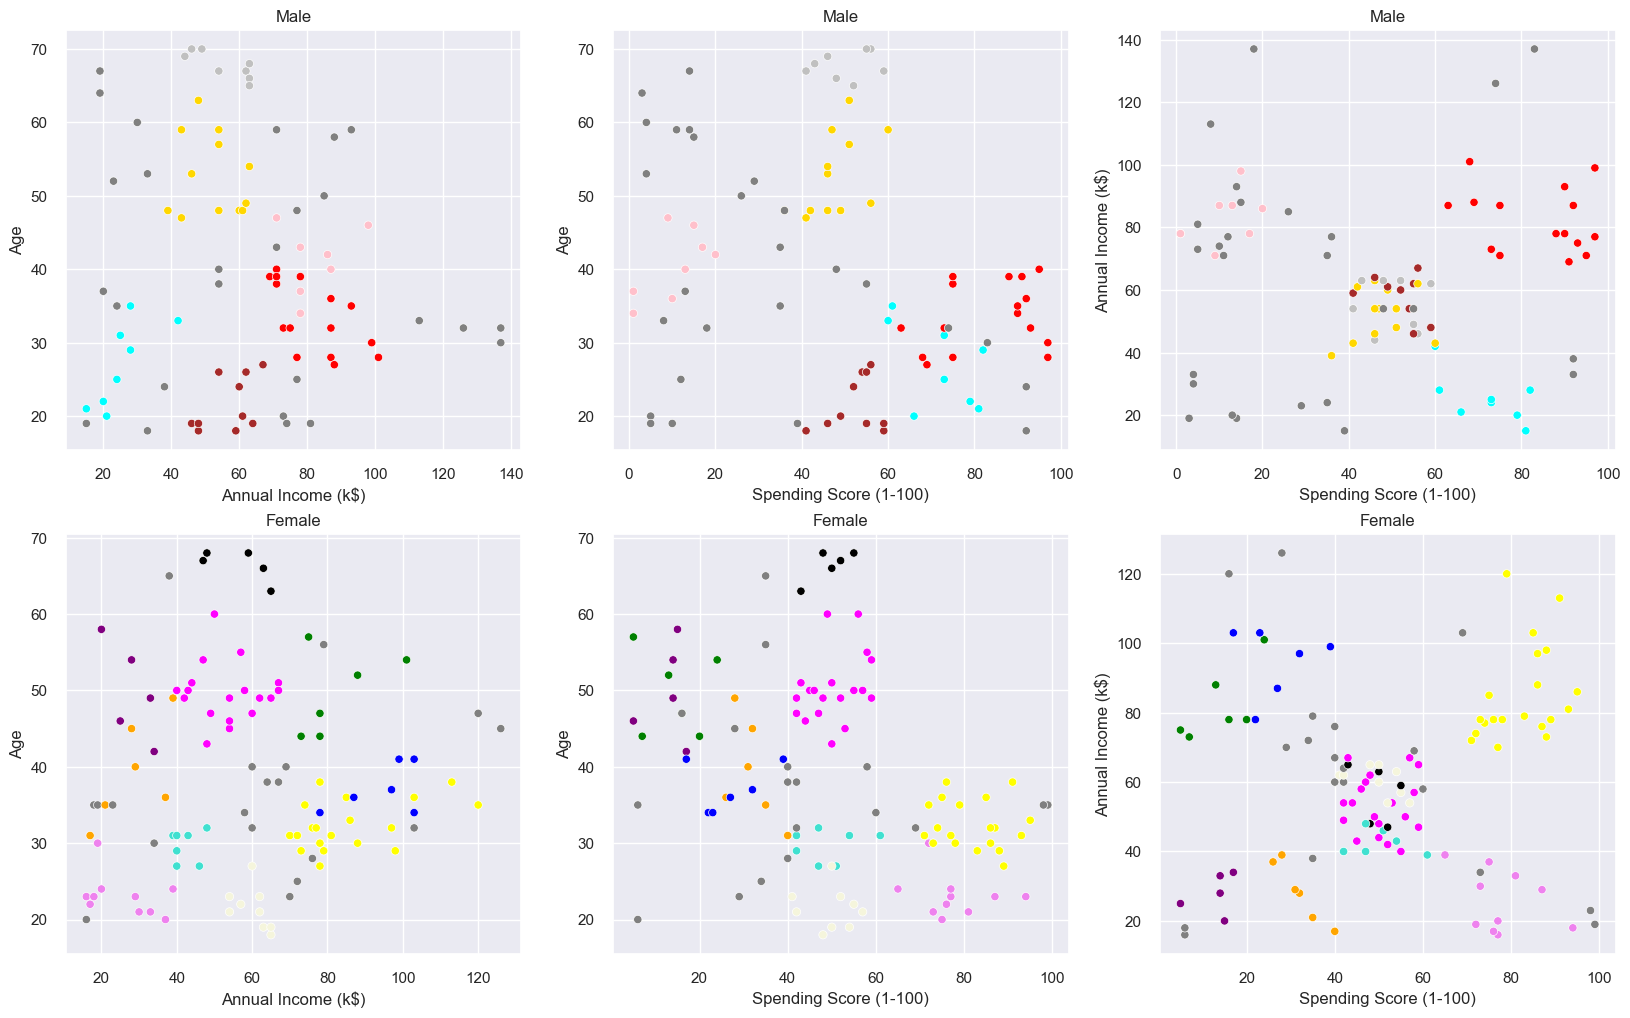

In [41]:
visualization_2d(data=data, col='hdbscan', cols=data.columns[1:], labels={
        'x': ['Annual Income (k$)', 'Spending Score (1-100)', 'Spending Score (1-100)'],
        'y': ['Age', 'Age', 'Annual Income (k$)']
})

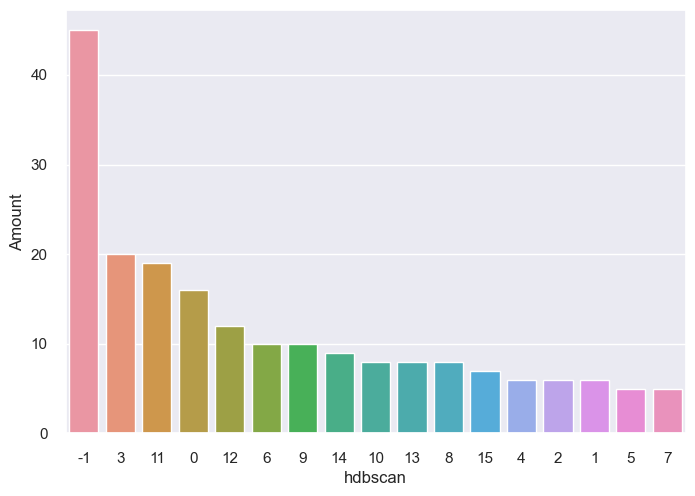

In [42]:
barplot_of_cluster_size(data, 'hdbscan')

In [43]:
info_by_cluster(data, 'hdbscan')

Age                   Annual Income (k$)         \
                  count       mean median               mean median   
hdbscan is_Female                                                     
-1      0            26  39.769231   37.5          64.038462   71.0   
        1            19  36.736842   35.0          61.684211   64.0   
 0      0            16  33.562500   33.0          81.562500   78.0   
 1      1             6  37.166667   36.5          94.500000   98.0   
 2      1             6  49.666667   49.5          82.166667   78.0   
 3      1            20  32.200000   31.5          85.200000   78.5   
 4      1             6  39.333333   38.0          28.500000   28.5   
 5      1             5  49.800000   49.0          28.000000   28.0   
 6      0            10  21.600000   19.5          56.900000   59.5   
 7      1             5  66.400000   67.0          56.400000   59.0   
 8      0             8  40.625000   41.0          82.875000   82.0   
 9      1            10  23.100000   23.0          25.800000   24.5   
 10     0             8  27.000000   27.0          25.375000   24.5   
 11     1            19  50.263158   50.0          53.210526   54.0   
 12     0            12  52.750000   51.0          52.250000   54.0   
 13     0             8  67.750000   67.5          55.500000   58.0   
 14     1             9  21.444444   21.0          60.222222   62.0   
 15     1             7  29.714286   31.0          42.285714   40.0   

                  Spending Score (1-100)         
                                    mean median  
hdbscan is_Female                                
-1      0                      30.000000   16.5  
        1                      44.736842   40.0  
 0      0                      83.187500   89.0  
 1      1                      26.666667   25.0  
 2      1                      14.166667   14.5  
 3      1                      82.300000   84.0  
 4      1                      32.000000   31.5  
 5      1                      13.000000   14.0  
 6      0                      52.600000   54.5  
 7      1                      49.600000   50.0  
 8      0                      10.750000   11.5  
 9      1                      77.700000   76.5  
 10     0                      71.875000   73.0  
 11     1                      50.263158   50.0  
 12     0                      47.583333   46.5  
 13     0                      50.000000   50.0  
 14     1                      49.888889   50.0  
 15     1                      49.142857   47.0

# Metrics: kmeans vs. meanshift vs. agglomerative vs. hdbscan

In [44]:
clustering_metrics = pd.DataFrame(data=[], index=list({ 
    *kmeans_metrics.keys(), *ms_metrics.keys(), *agglom_metrics.keys(), *hdbscan_metrics.keys() 
    }), columns=['kmeans', 'meanshift', 'agglomerative', 'ndbscan'])


for i in clustering_metrics.index:
  clustering_metrics.loc[i]['kmeans'] = kmeans_metrics.get(i, np.NaN)
  clustering_metrics.loc[i]['meanshift'] = ms_metrics.get(i, np.NaN)
  clustering_metrics.loc[i]['agglomerative'] = agglom_metrics.get(i, np.NaN)
  clustering_metrics.loc[i]['ndbscan'] = hdbscan_metrics.get(i, np.NaN)


display(clustering_metrics)

,kmeans,meanshift,agglomerative,ndbscan
wcss,98.717843,NaN,NaN,NaN
perc_of_noise,NaN,14.5,NaN,22.5
n_features_in_,4,4,4,4
silhouette_score,0.427833,0.644898,0.43446,0.678081
average_intrecluster_distance,19.345869,20.12107,NaN,19.628667
n_iter_,7,10,NaN,NaN
n_clusters,15,15,15,16
average_intracluster_distance,0.935416,0.94477,0.964778,0.683776
